## Run Exported Trained Model

In [1]:
# Import Package

import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
import glob

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging (1)
import pathlib
import tensorflow as tf

In [2]:
# GPU Memory Allocation

tf.get_logger().setLevel('ERROR')           # Suppress TensorFlow logging (2)
# Enable GPU dynamic memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
# Load Model

PATH_TO_SAVED_MODEL = r".\exported-models\Custom_SSDmobilenet_Various_OIDV6" + r"\saved_model"

print('Loading model...', end='')
start_time = time.time()

# Load saved model and build the detection function
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model...Done! Took 40.223286867141724 seconds


In [4]:
# Load Label Map

PATH_TO_LABELS = "annotations/label_map.pbtxt"
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,
                                                                    use_display_name=True)

In [5]:
# Load Image for Test

IMAGE_PATH_1 = glob.glob(r".\test-images\WA-Crop\*.jpg")
IMAGE_PATH_2 = glob.glob(r".\test-images\WA-Crop\*.jpeg")
IMAGE_PATHS = IMAGE_PATH_1 + IMAGE_PATH_2

Running inference for .\test-images\WA-Crop\727042.jpg... Done
Running inference for .\test-images\WA-Crop\IMG-20180108-WA0120.jpg... Done
Running inference for .\test-images\WA-Crop\WhatsApp Image 2021-06-08 at 2.53.09 PM (1).jpeg... Done
Running inference for .\test-images\WA-Crop\WhatsApp Image 2021-06-08 at 2.53.09 PM (2).jpeg... Done
Running inference for .\test-images\WA-Crop\WhatsApp Image 2021-06-08 at 2.53.09 PM (3).jpeg... Done
Running inference for .\test-images\WA-Crop\WhatsApp Image 2021-06-08 at 2.53.09 PM (4).jpeg... Done
Running inference for .\test-images\WA-Crop\WhatsApp Image 2021-06-08 at 2.53.09 PM.jpeg... Done


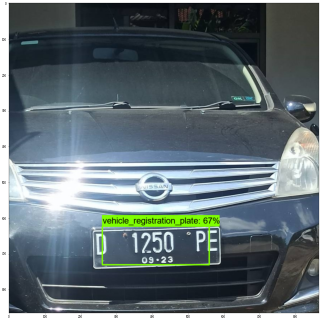

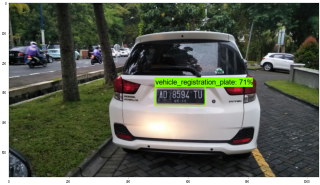

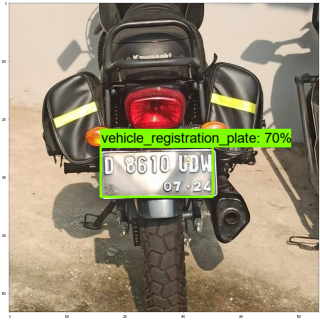

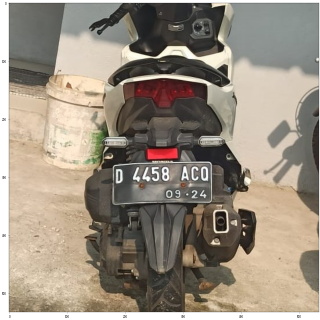

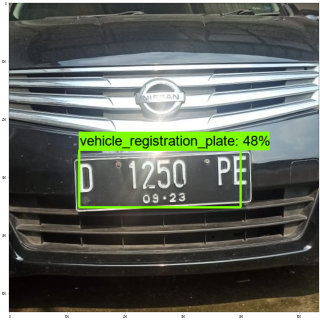

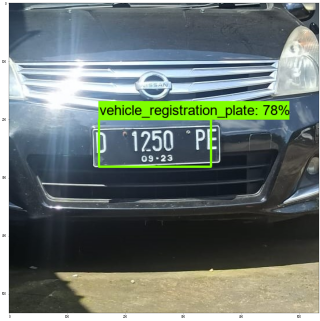

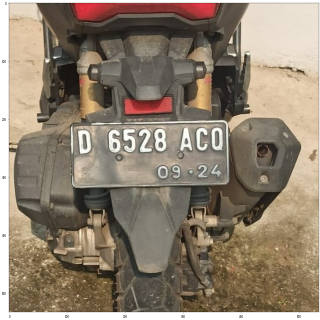

In [6]:
import numpy as np
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings

def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))

for image_path in IMAGE_PATHS:

    print('Running inference for {}... '.format(image_path), end='')

    image_np = load_image_into_numpy_array(image_path)

    # Things to try:
    # Flip horizontally
    # image_np = np.fliplr(image_np).copy()

    # Convert image to grayscale
    # image_np = np.tile(
    #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image_np)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]

    # input_tensor = np.expand_dims(image_np, 0)
    detections = detect_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                   for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'],
          detections['detection_classes'],
          detections['detection_scores'],
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=100,
          min_score_thresh=.4,
          agnostic_mode=False)

    plt.figure(figsize=(20, 25),dpi=20)
    plt.imshow(image_np_with_detections)
    print('Done')
plt.show()